In [406]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
from PIL import Image

def compare_images(images, titles=["Before", "After"]):
    plt.figure(figsize=(25,15))
    for i in range(2):
        plt.subplot(1,2,i+1)
        plt.imshow(images[i],'gray')
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

def display_image(image):
    display(Image.fromarray(image))

In [407]:
img = cv.imread("data/2 Баян-Өлгий/2-80/82_7584.jpeg")

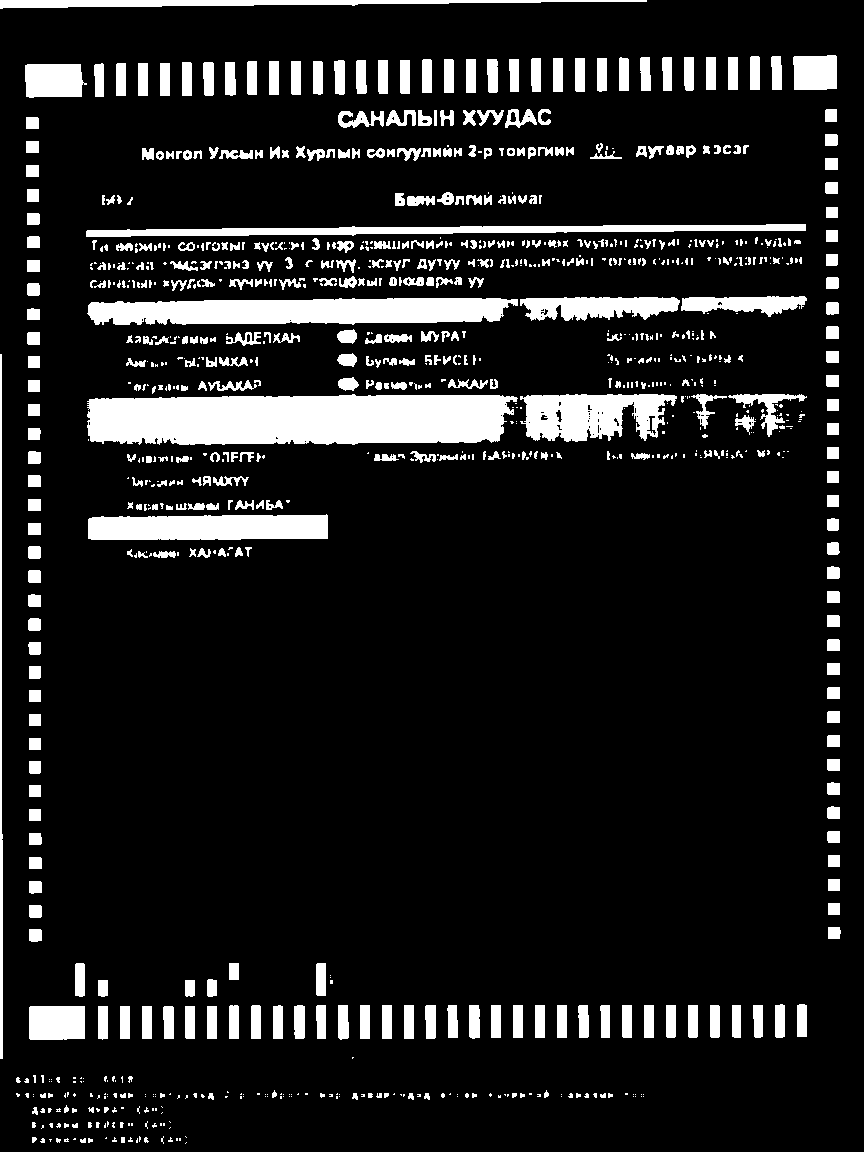

In [408]:
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
blur = cv.blur(gray,(3,3))
# gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)
_, threshold = cv.threshold(blur, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

display(Image.fromarray(threshold))

[array([[[80, 64]],

       [[81, 96]],

       [[26, 96]],

       [[25, 65]]], dtype=int32), array([[[836,  56]],

       [[836,  88]],

       [[794,  89]],

       [[794,  56]]], dtype=int32), array([[[  84, 1006]],

       [[  84, 1038]],

       [[  29, 1038]],

       [[  30, 1006]]], dtype=int32)]


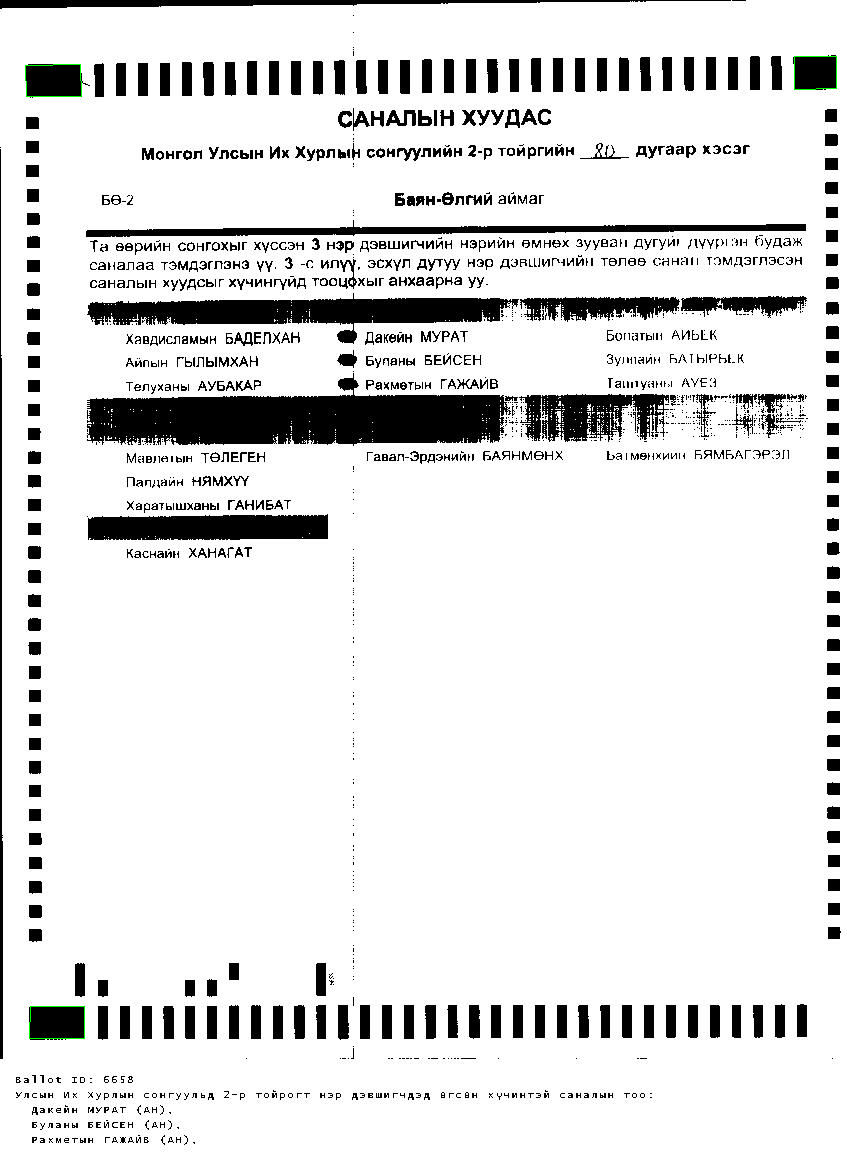

In [409]:
height, width = threshold.shape
image = threshold.copy()

filtered_contours = []
for area in [image[0:200, 0:200], image[0:200, width - 200:width], image[height - 200:height, 0:200]]:
    contours, hierarchy = cv.findContours(area, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    convexed_contours = [cv.convexHull(c) for c in contours]

    rectangles = []
    for c in convexed_contours:
        polygon = cv.approxPolyDP(c, 0.1 * cv.arcLength(c, True), True) 
        if len(polygon) == 4:
            rectangles.append(polygon)
    
    sorted_rectangles = sorted(rectangles, key=lambda x: cv.contourArea(x), reverse=True)
    filtered_contours.append(sorted_rectangles[0])

right_contour = np.array([[[point[0][0]+(width-200), point[0][1]]] for point in filtered_contours[1].tolist()], np.int32)
bottom_contour = np.array([[[point[0][0], point[0][1]+(height-200)]] for point in filtered_contours[2].tolist()], np.int32)
contours = [filtered_contours[0], right_contour, bottom_contour]

# Булангийн гурван дөрвөлжин тэмдэгнүүд
contoured = cv.drawContours(img, contours, -1, (0,255,0), 1)
print(contours)
display_image(contoured)

In [410]:
ordered_contours = []
for contour in contours:
    points = np.concatenate(contour)
    x_ordered = sorted(points, key=lambda x: x[0])

    left_top, left_bottom = sorted(x_ordered[:2], key=lambda x: x[1])
    right_top, right_bottom = sorted(x_ordered[2:], key=lambda x: x[1])
    ordered_contours.append((left_top, right_top, left_bottom, right_bottom))
print([point.tolist() for c in ordered_contours for point in c])
top_left = ordered_contours[0][2]
top_right = ordered_contours[1][3]
bottom_left = ordered_contours[2][2]
bottom_right = [top_right[0], bottom_left[-1]]

print("Coordinates: ", top_left, top_right, bottom_left, bottom_right)

[[25, 65], [80, 64], [26, 96], [81, 96], [794, 56], [836, 56], [794, 89], [836, 88], [30, 1006], [84, 1006], [29, 1038], [84, 1038]]
Coordinates:  [26 96] [836  88] [  29 1038] [836, 1038]


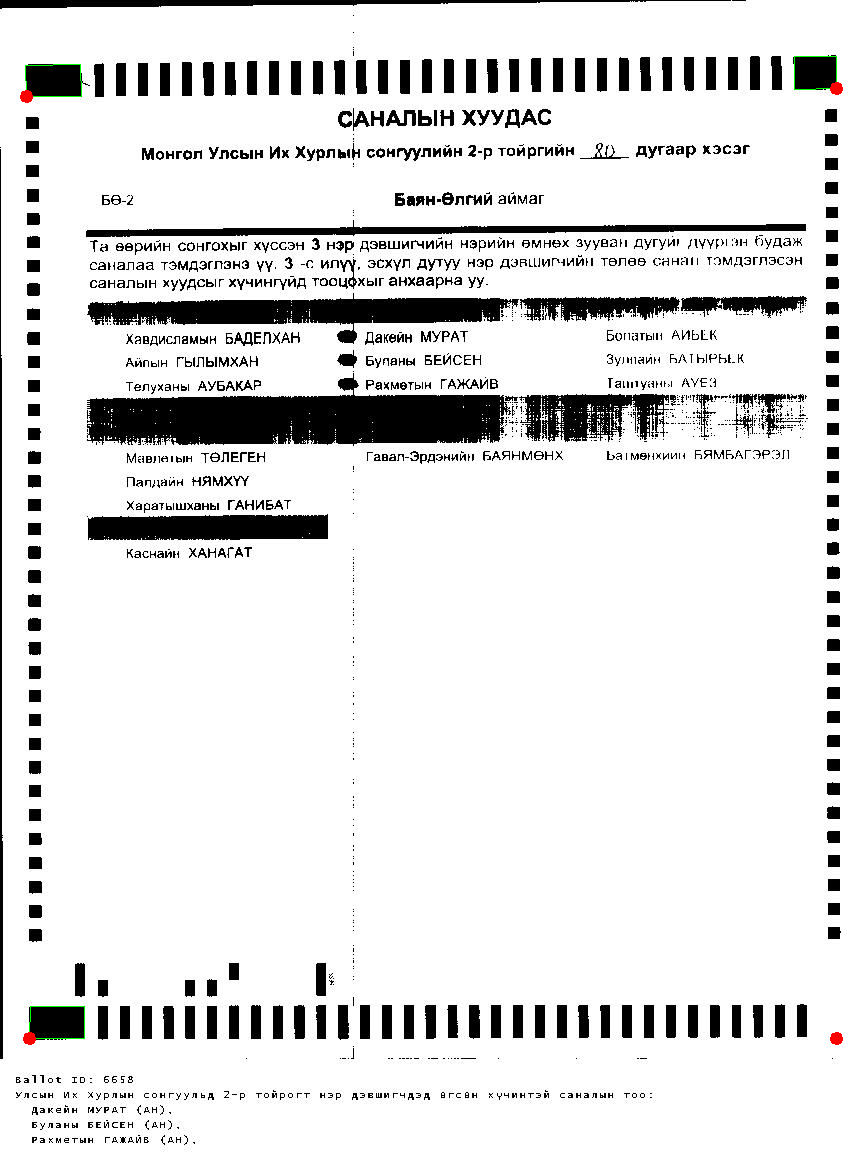

In [411]:
# Хамгийн захын цэгүүд
presentable = np.copy(img)
for origin in top_left, top_right, bottom_left, bottom_right:
    cv.circle(presentable, origin, 3, (255,0,0), 5)

display_image(presentable)

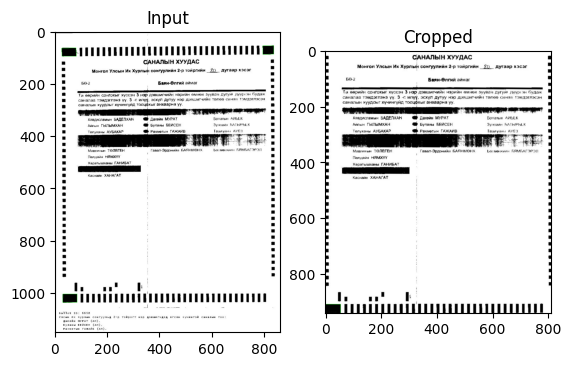

In [412]:
width = top_right[0] - top_left[0]
height = bottom_left[1] - top_left[1]
rows, cols, ch = img.shape

pts1 = np.float32([top_left, top_right, bottom_left, bottom_right])
pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])

matrix = cv.getPerspectiveTransform(pts1, pts2)
cropped = cv.warpPerspective(img, matrix, (width, height))

plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(cropped),plt.title('Cropped')
plt.show()
# cv.imwrite("./process/cropped-image.jpeg", cropped)

In [413]:
original = cv.imread("./cropped-image.jpeg")
height, width, _ = original.shape
print(original.shape)
img = cv.cvtColor(original, cv.COLOR_BGR2GRAY)

kernel = np.ones((5,5),np.uint8)
# blur = cv.GaussianBlur(img, (9, 9), 0)
# blur = cv.morphologyEx(blur, cv.MORPH_CLOSE, kernel)
_, threshold = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

marks = [(1, 10), (1, 11), (1, 12), (12, 10), (12, 11), (23, 10), (23, 11)]

x_step = 11
y_step = 12
x_start = 66
y_start = 20

for index, step in enumerate(range(x_start, width-42, x_step), start=1):
    if index in [1, 3, 23, 25, 45, 47]:
        cv.line(original, [step, 0], [step, height], (255, 0, 0), 2)

for index, step in enumerate(range(y_start, height-92, y_step), start=1):
    if index in [1, 19, 20, 21, 22, 23, 24, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40]:
        cv.line(original, [0, step], [width, step], (255, 0, 0), 2)


# for x, y in marks:
#     left = x_start + 2 * x_step * (x - 1)
#     right = left + x_step * 2

#     top = y_start + 2 * y_step * (y - 1)
#     bottom = top + y_step

#     # cv.line(original, [left, top], [left, bottom], (255, 0, 0), 2)
#     # cv.line(original, [right, top], [right, bottom], (255, 0, 0), 2)
#     # cv.line(original, [left, top], [right, top], (255, 0, 0), 2)
#     # cv.line(original, [left, bottom], [right, bottom], (255, 0, 0), 2)
#     cropped = original[top:bottom, left+5:right-5]

#     display_image(cropped)
display_image(original)


[ WARN:0@118154.453] global loadsave.cpp:248 findDecoder imread_('./cropped-image.jpeg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'